***
# **Small-MOCCA: Dataset exploration, feature computation and visualization**

***
Exploration of a subset of the MOCCA Survey Dataset I. Generation of features for ML Analysis. Description of processing functions and visualization functions.

> Programs by J.Saavedra-Bastidas.
***

## **$\bullet$ Preamble: Functions and Dependencies for Data Processing**

The `LEMONsc` Repository its intended to work within the docker container, with the libraries and dependencies listed in bowth `Dockerfile` and `requirements.txt`. Please check that dependencies are working and that contains compatible versions.

In [1]:
# General Libraries ---------------------------------------------------------------------------------------------#
import os
import random 

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
#----------------------------------------------------------------------------------------------------------------#

In [2]:
# Funtions and utilities ----------------------------------------------------------------------------------------#
from matplotlib.colors import LogNorm
from typing            import Dict, List, Tuple, Optional, Union
from dataclasses       import dataclass
#----------------------------------------------------------------------------------------------------------------#

In [3]:
# Change to working directory -----------------------------------------------------------------------------------#
os.chdir("../")
#----------------------------------------------------------------------------------------------------------------#

In [4]:
# Custome functions ---------------------------------------------------------------------------------------------#

# Exploration of files in a directory
from src.utils.directory  import list_all_directories

# Computation of physical quantities (derived from main parameters in the simulation)
from src.utils.phyfactors import relaxation_time, collision_time, core_collapse_time, crossing_time
from src.utils.phyfactors import critical_mass, rho_at_rh, mean_stellar_radius, safronov_num

# Data handling of files from the directory
from src.processing.dataset import load_moccasurvey_imbh_history

# Data handling of files (modules for preprocessing)
from src.processing.modules.simulations  import SimulationProcessor
from src.processing.modules.processor    import DataProcessor
from src.processing.modules.downsampling import DownsamplingProcessor

# Plot vizualization
from src.utils.visualize import plot_simulation_example
from src.utils.visualize import dataset_2Dhist, dataset_2Dhist_comparison, truncate_colormap
#----------------------------------------------------------------------------------------------------------------#

## **$\bullet$ Simulation files: Exploration of the MOCCA Survey dataset I**

For this project the preliminar information will always be stored at path: 
- Datapath: "./rawdata/moccasurvey/simulations/*"

We will reffer to the information from the MOCCA Survey Dataset I as *moccasurvey*. 

> **Note**:   
> All simulations have a respective folder with two directory files:
>   - system.txt: Temporal evolution of the initial conditions.
>   - imbh-history.txt: Temporal evolution of the most massive object in the simulation.
>
> **Custom Function**:
>
>   - `list_all_directories()`: Retrieve the path to all folders (simulations in this case) contained in the moccasurvey directory path

In [5]:
# Load name files and directories -------------------------------------------------------------------------------#
sim_files_path = "./rawdata/moccasurvey/simulations/"
simulations    = list_all_directories(sim_files_path)

# Verbose
print(110*"_")
print(f"Total MOCCA Models available for analysis: {len(simulations)}")
print(110*"_")
#----------------------------------------------------------------------------------------------------------------#

______________________________________________________________________________________________________________
Total MOCCA Models available for analysis: 455
______________________________________________________________________________________________________________


We can make a case study for a single simulation using the function `load_moccasurvey_imbh_history()`. Each simulation file contains several elements that can be retrieved given the input:

- **imbh_df**: main dataframe with the evolution history of the most massive object in the simulation
- **imbh_init_conds**: first rows of the imbh-history file, containing some initial conditions
- **imbh_col_dict**: description of the headers in the imbh_df.
- **imbh_stellar_dict**: dictionary to map the stellar type present in the imbh_df
- **system_df**: main dataframe with the evolution of the initial conditions of the simulation
- **system_col_dict**: description of the headers in the system_df.

In [21]:
# Load simulation info ------------------------------------------------------------------------------------------#
imbh_history, system = load_moccasurvey_imbh_history(file_path = f"{simulations[34]}/",
                                                    init_conds_sim  = True,
                                                    col_description = True,
                                                    stellar_map     = True,
                                                    init_conds_evo  = True)

imbh_history, system = load_moccasurvey_imbh_history(file_path = './rawdata/moccasurvey/simulations/n_1200000__zini_0.001__fracb_0.95__w0_6.0__iq_1__isemi_4__ikroupa_1__rbar_60.0__rplum_50.0__kfallb_0/',
                                                    init_conds_sim  = True,
                                                    col_description = True,
                                                    stellar_map     = True,
                                                    init_conds_evo  = True)

# Getting imbh history df, initial_conditions, column definitions, and stellar type mappig
imbh_df           = imbh_history[0]
imbh_init_conds   = imbh_history[1]
imbh_col_dict     = imbh_history[2]
imbh_stellar_dict = imbh_history[3]

# Retrive temporal evolution df of initial conditions and their column descriptions
system_df       = system[0]
system_col_dict = system[1]
#----------------------------------------------------------------------------------------------------------------#

In [22]:
# Columns of interest and details of the system df ....----------------------------------------------------------#
int_cols = ["17", "3", "23", "46", "44", "28", "2", "11"]

print(110*"_")
print("Columns of interest in the system dataframe")
for n_col in int_cols:
    print(110*"_")
    print(f"Column number      : {n_col}")
    print(f"Column name        : {system_col_dict[n_col]['column']}")
    print(f"Column description : {system_col_dict[n_col]['description']}")

print(110*"_")
print("Details of interest in the system dataframe")
print(f"Number of rows               : {len(system_df)}")
print(f"Maximun evolution time [Myrs]: {system_df['tphys'].max()}")
print(110*"_")
#----------------------------------------------------------------------------------------------------------------#

______________________________________________________________________________________________________________
Columns of interest in the system dataframe
______________________________________________________________________________________________________________
Column number      : 17
Column name        : r_h
Column description : actual half-mas radius in pc
______________________________________________________________________________________________________________
Column number      : 3
Column name        : smt
Column description : total mass in Msun
______________________________________________________________________________________________________________
Column number      : 23
Column name        : vc
Column description : central velocity dispersion in km/s (mass weighted)
______________________________________________________________________________________________________________
Column number      : 46
Column name        : nt
Column description : actual number of objects

In [23]:
# Columns of interest and details of the history df ....---------------------------------------------------------#
int_cols = ["4", "10", "11"]

print(110*"_")
print("Columns of interest in the imbh history dataframe")
for n_col in int_cols:
    print(110*"_")
    print(f"Column number      : {n_col}")
    print(f"Column name        : {imbh_col_dict[n_col]['column']}")
    print(f"Column description : {imbh_col_dict[n_col]['description']}")

print(110*"_")
print("Details of interest in the imbh history dataframe")
print(f"Number of rows         : {len(imbh_df)}")
print(f"Maximun evolution time : {imbh_df['time[Myr]'].max()}")
print(110*"_")
#----------------------------------------------------------------------------------------------------------------#

______________________________________________________________________________________________________________
Columns of interest in the imbh history dataframe
______________________________________________________________________________________________________________
Column number      : 4
Column name        : time
Column description : Time of the event in Myr
______________________________________________________________________________________________________________
Column number      : 10
Column name        : massNew
Column description : Mass of the primary after the event [Msun]
______________________________________________________________________________________________________________
Column number      : 11
Column name        : massCompNew
Column description : Mass of the companion after the event [Msun]
______________________________________________________________________________________________________________
Details of interest in the imbh history dataframe
Number of 

In [24]:
# Extract the example of initial conditions ---------------------------------------------------------------------#
rh      = system_df["r_h"][0]
v_disp  = system_df["vc"][0]
m_tot   = system_df["smt"][0]
n       = system_df["nt"][0]
m_mean  = system_df["atot"][0]
m_max   = system_df["smsm"][0]
cr      = system_df["rc"][0]
tau     = imbh_df["time[Myr]"].max() - imbh_df["time[Myr]"].min()

print(100*"_")
print("Initial conditions for the selected simulation:")
print(100*"_")
print(f"  - Half-mass radius (r_h)             : {rh:.3f} pc")
print(f"  - Velocity dispersion (v_disp)       : {v_disp:.3f} km/s")
print(f"  - Total mass (m_tot)                 : {m_tot:.3e} Msun")
print(f"  - Number of stars (n)                : {n}")
print(f"  - Mean stellar mass (m_mean)         : {m_mean:.3f} Msun")
print(f"  - Maximum stellar mass (m_max)       : {m_max:.3f} Msun")
print(f"  - Core radius (rc)                   : {cr:.3f} pc")
print(f"  - Cluster total evolution time (tau) : {tau:.3f} Myr")
print(100*"_")
#----------------------------------------------------------------------------------------------------------------#

____________________________________________________________________________________________________
Initial conditions for the selected simulation:
____________________________________________________________________________________________________
  - Half-mass radius (r_h)             : 1.200 pc
  - Velocity dispersion (v_disp)       : 54.428 km/s
  - Total mass (m_tot)                 : 1.083e+06 Msun
  - Number of stars (n)                : 1200000
  - Mean stellar mass (m_mean)         : 0.903 Msun
  - Maximum stellar mass (m_max)       : 87.891 Msun
  - Core radius (rc)                   : 0.649 pc
  - Cluster total evolution time (tau) : 14998.514 Myr
____________________________________________________________________________________________________


Relevant physical quatities can be computed with the functions stores in `phyfactors.py`. We leverage `astropy` to handle unit conversion. It's possible to compute values for the initial conditions (**point-wise**) of the simulation, or if you have the full evolution of parameters, deliver a list and compute the derived values **element-wise** *(see Visualization secction for an example)*:

In [25]:
# Compute an example of the relevant physical quantities (Initial values -----------------------------------------#
rh      = system_df["r_h"][0]
v_disp  = system_df["vc"][0]
m_tot   = system_df["smt"][0]
n       = system_df["nt"][0]
m_mean  = system_df["atot"][0]
m_max   = system_df["smsm"][0]
cr      = system_df["rc"][0]
tau     = imbh_df["time[Myr]"].max()

# Approximation of the average stellar radius
r_mean, r_unit = mean_stellar_radius(m_mean)

# Relevant timescales
t_relax, u_relax = relaxation_time(n_stars=n, hm_radius=rh, v_disp=v_disp, mtot=None)
t_cross, u_cross = crossing_time(hm_radius=rh, v_disp=v_disp, mtot=None)
t_coll,  u_coll  = collision_time(hm_radius=rh, n_stars=n, mass_per_star=m_mean, v_disp=v_disp, 
                                  stellar_radius=r_mean)
t_cc,    u_cc    = core_collapse_time(m_mean=m_mean, m_max=m_max, n_stars=n, hm_radius=rh, v_disp=v_disp, 
                                      mtot=None)  

# Density
rho_half, u_half = rho_at_rh(n_stars=n, hm_radius=rh)

# Critical mass
M_crit, u_crit = critical_mass(hm_radius=rh, mass_per_star=m_mean, cluster_age=tau, v_disp=v_disp, 
                               stellar_radius=r_mean)
safnum, u_saf  = safronov_num(mass_per_star=m_mean, v_disp=v_disp, stellar_radius=r_mean)

# Verbose
print(100*"_")
print("Physical timescales and quantities:")
print(100*"_")
print(f"  Initial average stellar radius      (r_stellar) : {r_mean[0]:.3f}, {r_unit}")
print(f"  Initial relaxation time             (t_relax)   : {t_relax[0]:.3f}, {u_relax}")
print(f"  Initial crossing time               (t_relax)   : {t_cross[0]:.3f}, {u_cross}")
print(f"  Initial collision time              (t_coll))   : {t_coll[0]:.3e}, {u_coll}")
print(f"  Initial core collapse time          (t_cc)      : {t_cc[0]:.3f}, {u_cc}")
print(f"  Initial density at half-mass radius (rho_rh)    : {rho_half[0]:.3e}, {u_half}")
print(f"  Critical mass (with tau = t_end)    (M_crit)    : {M_crit[0]:.3e}, {u_crit}")
print(f"  Safronov Number                     (Theta)     : {safnum[0]:.3f}, {u_saf}")
print(100*"_")
#----------------------------------------------------------------------------------------------------------------#

____________________________________________________________________________________________________
Physical timescales and quantities:
____________________________________________________________________________________________________
  Initial average stellar radius      (r_stellar) : 0.938, solRad
  Initial relaxation time             (t_relax)   : 189.008, Myr
  Initial crossing time               (t_relax)   : 0.022, Myr
  Initial collision time              (t_coll))   : 5.341e+05, Myr
  Initial core collapse time          (t_cc)      : 6.406, Myr
  Initial density at half-mass radius (rho_rh)    : 8.289e+04, 1 / pc3
  Critical mass (with tau = t_end)    (M_crit)    : 6.750e+06, solMass
  Safronov Number                     (Theta)     : 30.997, 
____________________________________________________________________________________________________


## **$\bullet$ Visualization (Single simulation)**

The functions `time_preparation()` and `target_preparation()` allow for a simpler clean up of the simulation main quantities (drop duplicates, NaNs, some filters for smoother transition, etc. Check documentation for more details). To visualize a single simulation file already loaded into a DataFrame, you can use `plot_simulation_example()`:

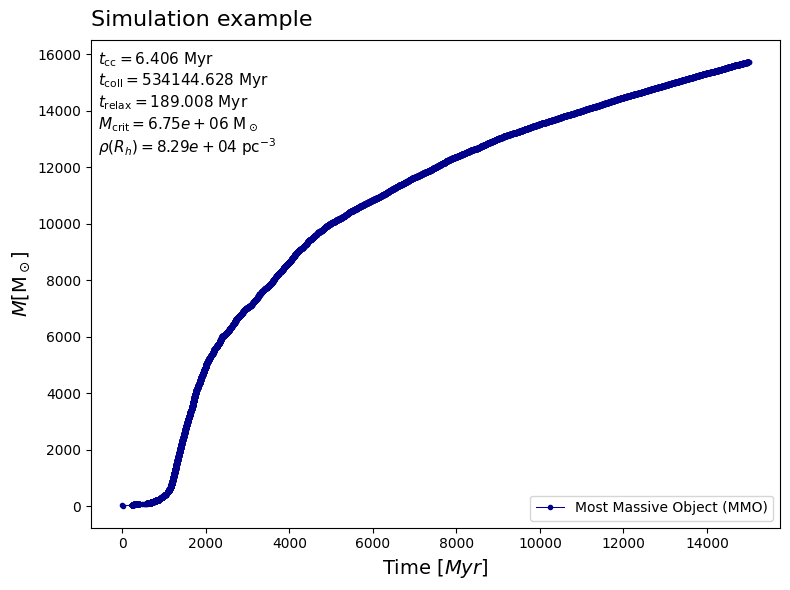

In [26]:
# We can plot a random example of a simulation and some relevan quantities of interest --------------------------#
example_df = imbh_df.drop_duplicates(subset="time[Myr]").sort_values(by='time[Myr]')

plot_simulation_example(df=example_df,
                        t_relax   = t_relax[0],
                        t_coll    = t_coll[0],
                        t_cc      = t_cc[0],
                        rho_half  = rho_half[0],
                        M_crit    = M_crit[0],
                        show      = True)
#----------------------------------------------------------------------------------------------------------------#

We can retrieve the evolution of the physical conditions of interest for each time-step also. Elements inside the system_df don't share most of the time the same temporal resolution, so we performed an interpolation between thems to match snapshot elements:

In [27]:
# Use merge_asof to align system_df to imbh_df times ------------------------------------------------------------#
matched_system_df = pd.merge_asof(example_df[["time[Myr]"]], system_df,
                                  left_on   = "time[Myr]",
                                  right_on  = "tphys",
                                  direction = "nearest")
#----------------------------------------------------------------------------------------------------------------#

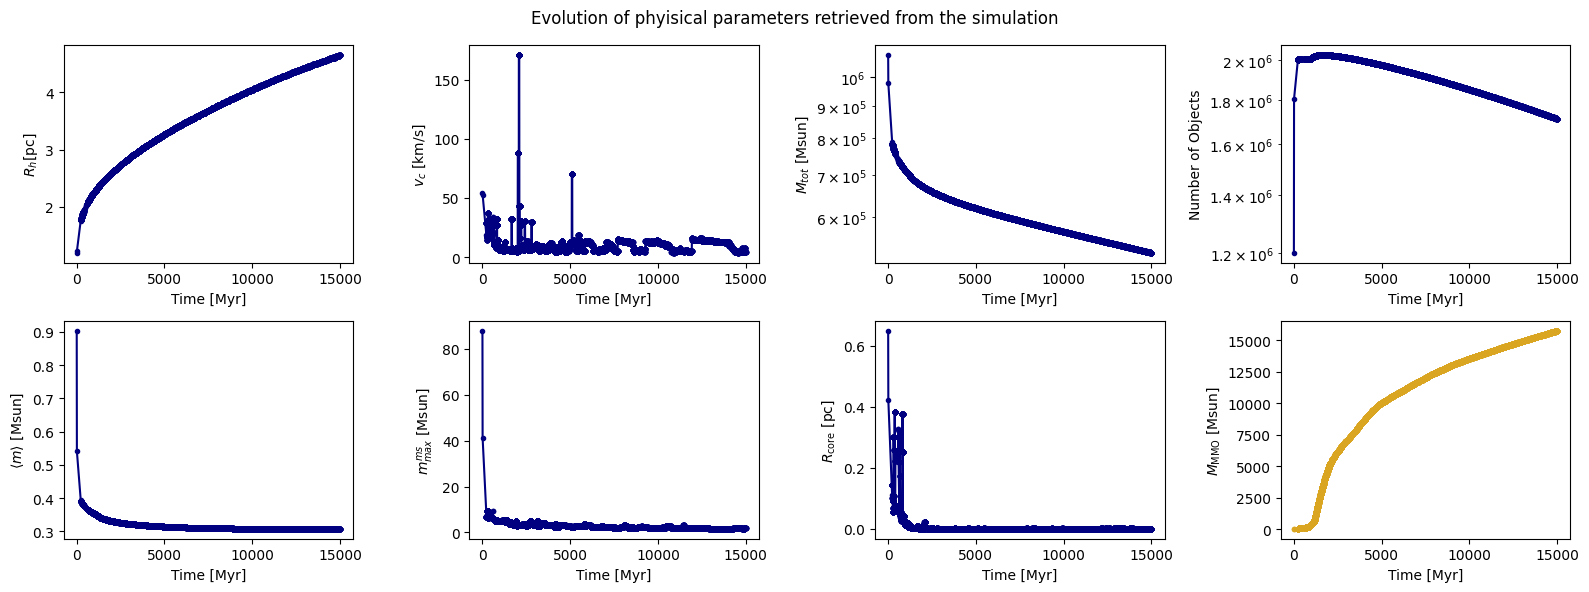

In [29]:
# Select quantities of interest ---------------------------------------------------------------------------------#
time   = example_df["time[Myr]"]
mmmo   = example_df["massNew[Msun](10)"]

rh     = matched_system_df["r_h"]
v_disp = matched_system_df["vc"]
m_tot  = matched_system_df["smt"]
n      = matched_system_df["nt"]
m_mean = matched_system_df["atot"]
m_max  = matched_system_df["smsm"]
cr     = matched_system_df["rc"]
tau    = np.max(time) - time

# plot elements
quantities = [rh, v_disp, m_tot, n, m_mean, m_max, cr, mmmo]
ylabels    = [r"$R_h$[pc]", r"$v_c$ [km/s]", r"$M_{tot}$ [Msun]", 
              r"Number of Objects",  r"$\langle m \rangle$ [Msun]", 
              r"$m_{max}^{ms}$ [Msun]", r"$R_{\rm{core}}$ [pc]", r"$M_{\rm{MMO}}$ [Msun]"]
xlabels    = ["Time [Myr]"] * len(quantities)

# Crear figura 2x4
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
axes = axes.flatten()  

# Iterar sobre cada cantidad
for i, (ax, y, yl, xl) in enumerate(zip(axes, quantities, ylabels, xlabels)):
    ax.plot(time, y, lw=1.5, marker =".", color='goldenrod' if i ==7 else "navy")
    ax.set_xlabel(xl)
    ax.set_ylabel(yl)
    ax.grid(False)
    if (i == 2) or (i == 3):
        ax.set_yscale("log")
fig.suptitle("Evolution of phyisical parameters retrieved from the simulation")

# Si sobran subplots (porque son 8 y solo usas 7)
if len(quantities) < len(axes):
    for j in range(len(quantities), len(axes)):
        fig.delaxes(axes[j])  

plt.tight_layout()
plt.savefig('./plot_3.jpg', dpi=700, bbox_inches="tight")
plt.show()
plt.close()
#----------------------------------------------------------------------------------------------------------------#

And use the same functions but with the full lists to compute the evolution of the physical timescales or representative features of the simulations : 


In [16]:
# Approximation of the average stellar radius -------------------------------------------------------------------#
r_mean, r_unit = mean_stellar_radius(m_mean)

# Relevant timescales
t_relax, u_relax = relaxation_time(n_stars=n, hm_radius=rh, v_disp=v_disp, mtot=None)
t_cross, u_cross = crossing_time(hm_radius=rh, v_disp=v_disp, mtot=None)
t_coll,  u_coll  = collision_time(hm_radius=rh, n_stars=n, mass_per_star=m_mean, v_disp=v_disp, 
                                  stellar_radius=r_mean)
t_cc,    u_cc    = core_collapse_time(m_mean=m_mean, m_max=m_max, n_stars=n, hm_radius=rh, v_disp=v_disp, 
                                      mtot=None)  

# Density
rho_half, u_half = rho_at_rh(n_stars=n, hm_radius=rh)

# Critical mass
M_crit, u_crit = critical_mass(hm_radius=rh, mass_per_star=m_mean, cluster_age=np.maximum(tau, 1e-5), v_disp=v_disp, 
                               stellar_radius=r_mean)
safnum, u_saf  = safronov_num(mass_per_star=m_mean, v_disp=v_disp, stellar_radius=r_mean)

# Avoid indeterminations by time 0
time = np.maximum(time, 1e-5)
#----------------------------------------------------------------------------------------------------------------#

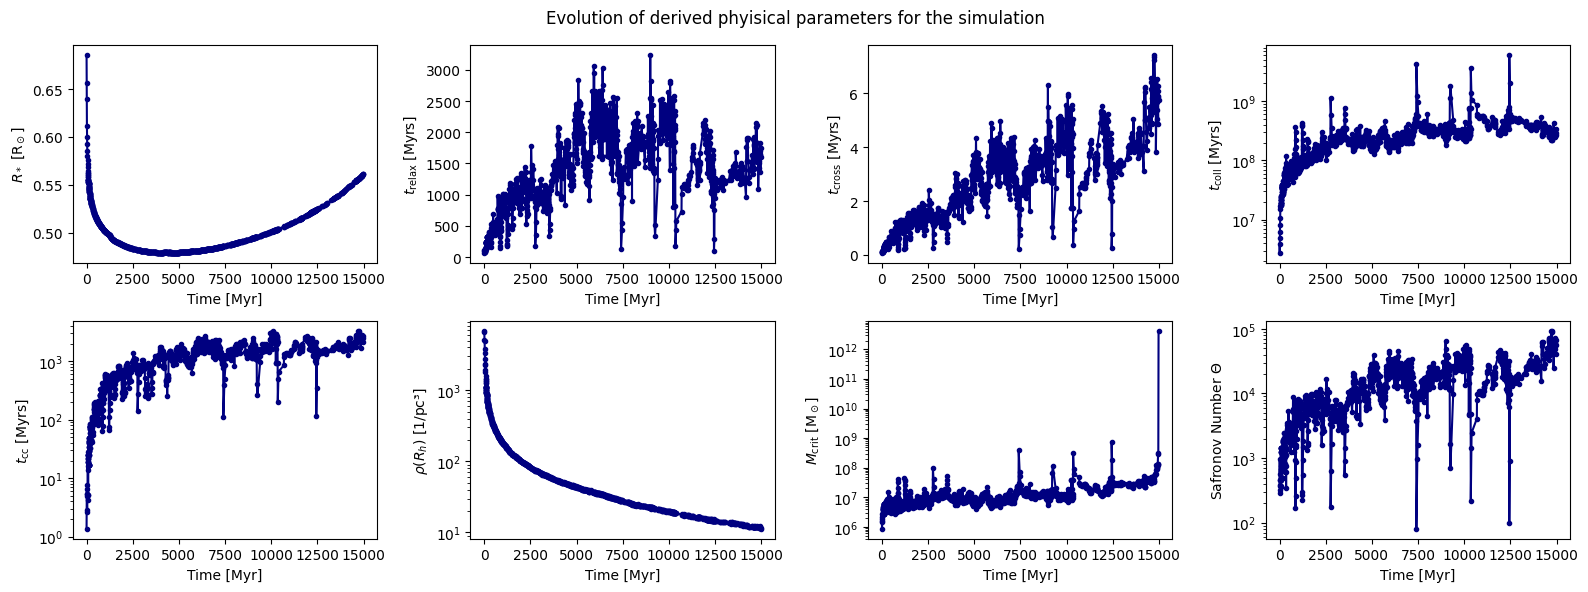

In [17]:
# plot elements -------------------------------------------------------------------------------------------------#
quantities = [r_mean, t_relax, t_cross, t_coll, t_cc, rho_half, M_crit, safnum]
ylabels    = [r"$R_*$ [R$_\odot$]",
              r"$t_{\rm{relax}}$ [Myrs]", r"$t_{\rm{cross}}$ [Myrs]", r"$t_{\rm{coll}}$ [Myrs]",  
              r"$t_{\rm{cc}}$ [Myrs]", r"$\rho(R_{h})$ [1/pc³]",
              r"$M_{\rm{crit}}$ [M$_\odot$]", r"Safronov Number $\Theta$"]
xlabels    = ["Time [Myr]"] * len(quantities)

# Create figure
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
axes = axes.flatten()  

# Plot each element in iteration
for i, (ax, y, yl, xl) in enumerate(zip(axes, quantities, ylabels, xlabels)):
    ax.plot(time , y, lw=1.5, marker =".", color="navy")
    ax.set_xlabel(xl)
    ax.set_ylabel(yl)
    ax.grid(False)
    if (i == 3) or (i == 4) or (i == 5) or (i == 6) or (i == 7):
        ax.set_yscale("log")

# Delete elements if necessary
if len(quantities) < len(axes):
    for j in range(len(quantities), len(axes)):
        fig.delaxes(axes[j])  

fig.suptitle("Evolution of derived phyisical parameters for the simulation")

plt.tight_layout()
plt.show()
plt.close()
#----------------------------------------------------------------------------------------------------------------#

## **$\bullet$ Visualization (Full Dataset)**

Now, if we want to do a full case-study for the dataset we need to retrieve the class `DataProcessor()` and indicate it where to find the simulations, together with internal condiguration parameters. The downsampling of the dateset can be initialized from `DownsamplingProcessor()`. The main arguments to made the full process are included inside the `ProcessingConfig()` dataclass. 

In [18]:
# A full retrieve of the simulations can be made with the following class ---------------------------------------#
@dataclass
class ProcessingConfig:
    """Configuration class for processing parameters."""
    points_per_sim: Union[int, float] = 0.80  # When sampling points from simulations, how many (if float its %)
    n_virtual: int = 10                       # How many virtual simulatinos we extract from one simulation
    train_split: float = 0.7                  # The training fraction of the split
    val_split: float = 0.2                    # The validation fraction of the split
    test_split: float = 0.1                   # The testing fraction of the split
    min_points_threshold: int = 1000          # The minimun number of points to consider a simulation
    histogram_bins: int = 200                 # The number of celds for the 2D histogram
    downsample_min_count: int = 10            # Minimun number of points per celd to consider
    downsample_max_count: int = 150           # Maximun number of points per celd to consider
    requires_temp_evol: bool = False          # Whether to use initial values
    sample_window : bool = False
    retain_order : bool =True
    

# Initialize config
config   = ProcessingConfig()

# Initialize Processors
sims_processor         = SimulationProcessor(config)
data_processor         = DataProcessor(config)
downsampling_processor = DownsamplingProcessor(config)
#----------------------------------------------------------------------------------------------------------------#

To process the full simulation dataset, you can call the function `process_simulations()` from the `sims_processor`. To retrieve the original elements of the simulation (without any posterior alterations), note that you need to explicitly specify *no augmentation*, *no noise*, and *no virtual sims*. It's important to know that most of the time, we require that an enviromental classification of the simulation exists. for this you can use the `classify_simulations_by_envirioment()` method.  

In [19]:
# Process simulations -------------------------------------------------------------------------------------------#

# select a smaller sample for testing purposes
r_simulations = random.sample(simulations, 200)
r_simulations = simulations
# Classify and save simulations by environment type (important for ca)
simulations_by_type = sims_processor.classify_simulations_by_environment(r_simulations)

# Relate path to label
path_to_label = {path: env_type
                for env_type, paths in simulations_by_type.items()
                for path in paths
                }

# Create label list 
labels = [path_to_label.get(path, np.nan) for path in r_simulations]
#----------------------------------------------------------------------------------------------------------------#

INFO: Loading classification from cache...
INFO: Loaded 38 FAST simulations from cache
INFO: Loaded 136 SLOW simulations from cache
INFO: Loaded 173 STEADY simulations from cache


The `data_processor.process_simulations()` will retrieve three different things, first the physical time of the simulation in Mega years, the mass evolution of the most massive object in the simulation, and the physical parameters (both delivered and derivated) in a fixed order (check documentation if needed). Depending wheter you chose to use temporal evolution parameter or not, the physical conditions would evolve over time or repeat `len(times)` per simulation. Note that this function gives you point-paired elements, and time series information is not explicit.

In [20]:
# Retrieve original simulations ---------------------------------------------------------------------------------#
t_base, m_base, phy_base, path_list = data_processor.process_simulations(
                                      r_simulations, labels,
                                      augmentation = False, 
                                      apply_noise  = False, 
                                      n_virtual    = None, 
                                      verbose      = True)
#----------------------------------------------------------------------------------------------------------------#

Processing simulations:   2%|█▎                                                                                   | 7/455 [00:03<03:11,  2.34sim/s]

Processing simulations:  18%|██████████████▊                                                                     | 80/455 [00:40<02:43,  2.29sim/s]

Processing simulations:  23%|███████████████████▎                                                               | 106/455 [00:51<02:33,  2.27sim/s]

Processing simulations:  58%|███████████████████████████████████████████████▉                                   | 263/455 [02:19<03:08,  1.02sim/s]

Processing simulations:  97%|████████████████████████████████████████████████████████████████████████████████▋  | 442/455 [03:54<00:06,  2.15sim/s]

Processing simulations: 100%|███████████████████████████████████████████████████████████████████████████████████| 455/455 [04:00<00:00,  1.89sim/s]

INFO: ______________________________________________________________________________________________________________
INFO: Simulation processing completed:
INFO: ______________________________________________________________________________________________________________
INFO:   - Total simulations processed   : 455
INFO:   - Simulations used              : 342
INFO:   - Simulations ignored           : 113
INFO:   - FAST formation channel sims   : 38
INFO:   - STEADY formation channel sims : 173
INFO:   - SLOW formation channel sims   : 131
INFO:   - Average points per simulation : 8709.1 ± 7201.1
INFO: ______________________________________________________________________________________________________________


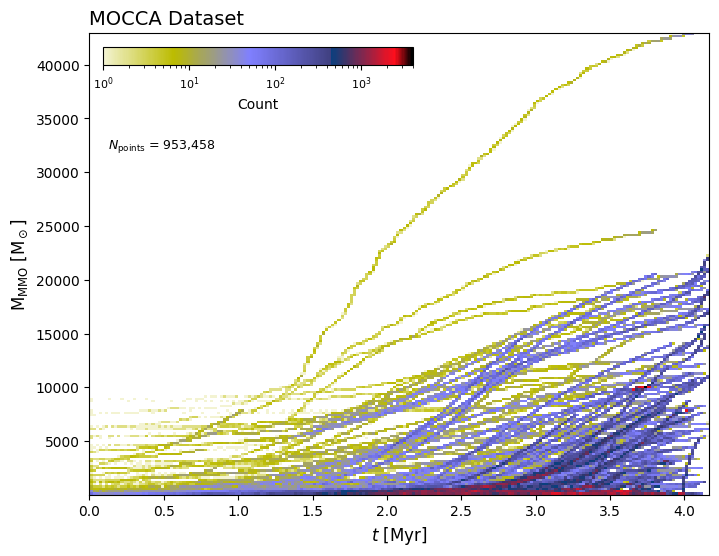

In [35]:
# You can visualize quantities using a 2D Histogram for better efficiency ---------------------------------------#

# Use a truncated colormap to avoid white colors
cmap_trunc = truncate_colormap("gist_stern_r")

# Plot elements
dataset_2Dhist(x_values   = np.log10(np.array(t_base)+1), 
               y_values   = np.array(m_base),
               name       = "m_mmo_evol",
               bins       = 200,
               cmap       = cmap_trunc,
               savepath   = None,
               figsize    = (8, 6),
               title      = "MOCCA Dataset",
               axislabels = (r"$t$ [Myr]", r"M$_{\rm{MMO}}$ [M$_\odot$]"),
               cmap_label = "Count",
               show      = True)
#----------------------------------------------------------------------------------------------------------------#

However, creating new *virtual simulations* can be relevant for safe training, and adding noise has both theoretical and practical advantages (the evolution of a simulation involves inherent stochasticity, and machine learning models can benefit from having similar yet slightly different points to learn from). For this purpose, augmentation can be called together with noise implementation (gaussian noise in this case).  

In [36]:
# Perform a sampling augmentation and noise addition to the simulations -----------------------------------------#
t_augm, m_augm, phy_augm = data_processor.process_simulations(
                            r_simulations, labels,
                            augmentation = True, 
                            apply_noise  = True, 
                            n_virtual    = config.n_virtual,
                            verbose      = True)
#----------------------------------------------------------------------------------------------------------------#

Processing simulations:  56%|██████████████▍           | 111/200 [00:09<00:05, 14.97sim/s]

Processing simulations:  62%|███████████████▉          | 123/200 [00:10<00:05, 14.22sim/s]

Processing simulations: 100%|██████████████████████████| 200/200 [00:17<00:00, 11.73sim/s]

INFO: ______________________________________________________________________________________________________________
INFO: Simulation processing completed:
INFO: ______________________________________________________________________________________________________________
INFO:   - Total simulations processed   : 200
INFO:   - Simulations used              : 146
INFO:   - Simulations ignored           : 54
INFO:   - Virtual simulations generated : 1460
INFO:   - Total effective simulations   : 1606
INFO:   - Avg virtual per original sim  : 10.0
INFO:   - FAST formation channel sims   : 15
INFO:   - STEADY formation channel sims : 80
INFO:   - SLOW formation channel sims   : 51
INFO:   - Average points per original   : 65305.3 ± 54830.1
INFO:   - Average points per output     : 65305.3 ± 54830.1
INFO: ______________________________________________________________________________________________________________


Finally, simulations are not balanced in the resulting values that mass can take, so a machine learning model could be biased toward areas of higher concentration in the parameter space. To address this, we can perform a random downsampling of these dense areas. While some information from the augmentation is lost, this approach produces a smoother feature space.

In [37]:
import numpy as np
import matplotlib.pyplot as plt

In [38]:
# Downsampling the simulations retrieved using the a 2d histogram -----------------------------------------------#
t_down, m_down, phy_down = downsampling_processor.perform_downsampling(t_augm, m_augm, phy_augm)
#----------------------------------------------------------------------------------------------------------------#

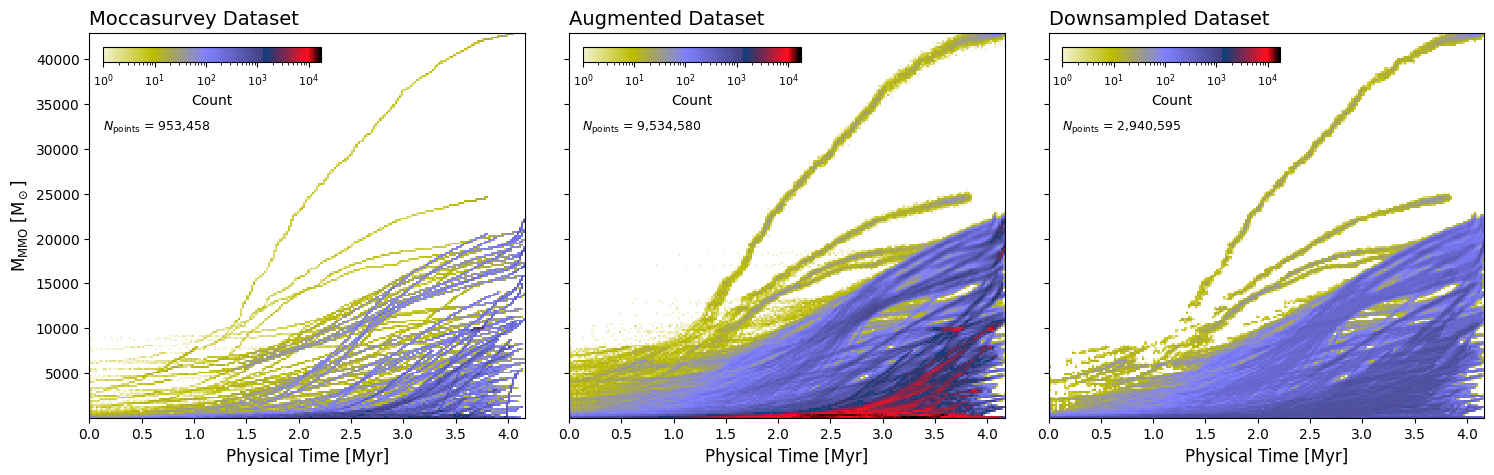

In [40]:
# Plot the files and observe the elements retrieved -------------------------------------------------------------#
cmap_trunc = truncate_colormap("gist_stern_r")
dataset_2Dhist_comparison(x_base = np.log10(np.array(t_base)+1), y_base = m_base, 
                          x_aug  = np.log10(np.array(t_augm)+1), y_aug  = m_augm,
                          x_filt = np.log10(np.array(t_down)+1), y_filt = m_down, 
                          titles     = ("Moccasurvey Dataset", "Augmented Dataset", "Downsampled Dataset"),
                          axislabels = (r"Physical Time [Myr]", r"M$_{\rm{MMO}}$ [M$_\odot$]"),
                          bins       = 200, 
                          cmap       = cmap_trunc,
                          show       = True) 
#----------------------------------------------------------------------------------------------------------------#